# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.training import TripletModel, triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [5]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Plotting

#### Training data

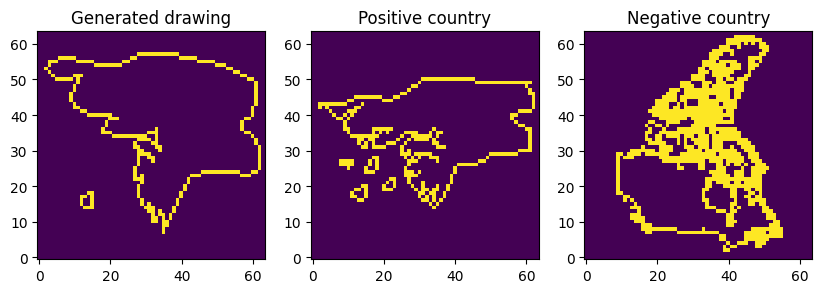

In [6]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

In [31]:
from countryguess.utils import poly_to_img

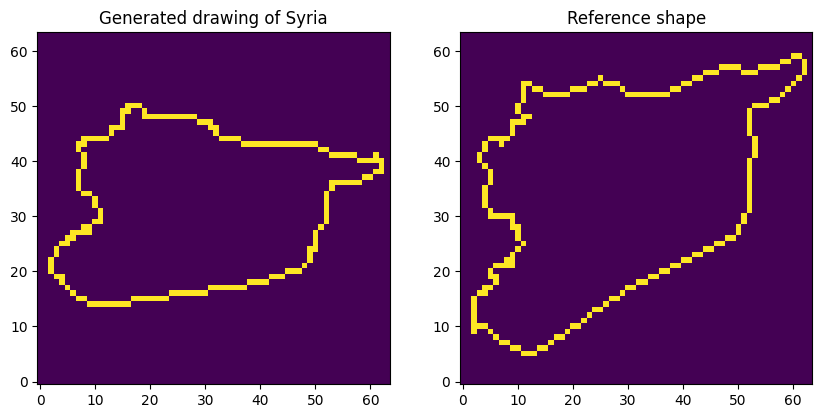

In [51]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

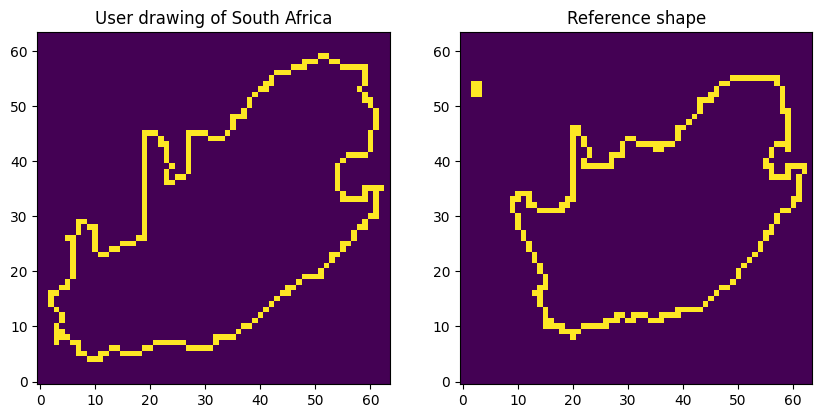

In [63]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [2]:
device = torch.device("mps")

In [3]:
mlflow.set_experiment("local")

params = {"channels": 4*random.randint(1, 6),
          "nr_conv_blocks": random.randint(2, 5),
          "embedding_size": 32*random.randint(2, 7),
          "shape": 32*random.randint(2, 5),
          "learning_rate": random.uniform(0.006, 0.012), 
          "margin": random.uniform(0.5, 1.5),
          "temperature": random.uniform(0.5, 1),
          "nr_epochs": random.randint(40, 100)}
print(params)

model = TripletModel(**params).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

{'channels': 8, 'nr_conv_blocks': 5, 'embedding_size': 192, 'shape': 64, 'learning_rate': 0.01176593882952329, 'margin': 1.4595559616249711, 'temperature': 0.6060127377344986, 'nr_epochs': 73}


In [5]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=32, num_workers=2)

In [6]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad()
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/73	 loss: 0.739
Epoch: 2/73	 loss: 0.352
Epoch: 3/73	 loss: 0.167
Epoch: 4/73	 loss: 0.247
Epoch: 5/73	 loss: 0.204
Epoch: 5/73	 Average rank: 20.13	 top 10 acc: 64.5%	 top 1 acc: 38.6%	
Epoch: 6/73	 loss: 0.165
Epoch: 7/73	 loss: 0.142
Epoch: 8/73	 loss: 0.099
Epoch: 9/73	 loss: 0.099
Epoch: 10/73	 loss: 0.103


/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x16f97a2c0, s0=(35.6314, 60.4064), s1=(35.6777, 60.3962), p=(35.6777, 60.3962), type=0, slope=-0.22030237580987155)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/augmentables/polys.py", line 2465, in _

Epoch: 10/73	 Average rank: 5.73	 top 10 acc: 86.8%	 top 1 acc: 57.9%	
Epoch: 11/73	 loss: 0.101
Epoch: 12/73	 loss: 0.134
Epoch: 13/73	 loss: 0.069
Epoch: 14/73	 loss: 0.065
Epoch: 15/73	 loss: 0.056
Epoch: 15/73	 Average rank: 3.82	 top 10 acc: 90.4%	 top 1 acc: 55.3%	
Epoch: 16/73	 loss: 0.086
Epoch: 17/73	 loss: 0.078
Epoch: 18/73	 loss: 0.064
Epoch: 19/73	 loss: 0.048
Epoch: 20/73	 loss: 0.076
Epoch: 20/73	 Average rank: 4.35	 top 10 acc: 91.4%	 top 1 acc: 58.9%	
Epoch: 21/73	 loss: 0.106
Epoch: 22/73	 loss: 0.111
Epoch: 23/73	 loss: 0.072
Epoch: 24/73	 loss: 0.055
Epoch: 25/73	 loss: 0.055
Epoch: 25/73	 Average rank: 3.93	 top 10 acc: 91.4%	 top 1 acc: 60.4%	
Epoch: 26/73	 loss: 0.076
Epoch: 27/73	 loss: 0.055
Epoch: 28/73	 loss: 0.074
Epoch: 29/73	 loss: 0.055
Epoch: 30/73	 loss: 0.017
Epoch: 30/73	 Average rank: 3.71	 top 10 acc: 92.9%	 top 1 acc: 59.4%	
Epoch: 31/73	 loss: 0.055
Epoch: 32/73	 loss: 0.088
Epoch: 33/73	 loss: 0.039
Epoch: 34/73	 loss: 0.058
Epoch: 35/73	 loss: 0

/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x31547fc40, s0=(6.2706, 24.9503), s1=(6.2928, 24.9566), p=(6.2928, 24.9566), type=0, slope=0.28378378378392544)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/GitHub/country-guess/env/lib/python3.12/site-packages/imgaug/augmentables/polys.py", line 2465, in _gene

Epoch: 60/73	 loss: 0.032
Epoch: 60/73	 Average rank: 2.26	 top 10 acc: 96.4%	 top 1 acc: 71.1%	
Epoch: 61/73	 loss: 0.100
Epoch: 62/73	 loss: 0.010
Epoch: 63/73	 loss: 0.020
Epoch: 64/73	 loss: 0.048
Epoch: 65/73	 loss: 0.098
Epoch: 65/73	 Average rank: 3.22	 top 10 acc: 90.9%	 top 1 acc: 62.4%	
Epoch: 66/73	 loss: 0.064
Epoch: 67/73	 loss: 0.106
Epoch: 68/73	 loss: 0.043
Epoch: 69/73	 loss: 0.019
Epoch: 70/73	 loss: 0.052
Epoch: 70/73	 Average rank: 2.66	 top 10 acc: 94.4%	 top 1 acc: 65.0%	
Epoch: 71/73	 loss: 0.027
Epoch: 72/73	 loss: 0.031
Epoch: 73/73	 loss: 0.075


### Evaluate model

In [10]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

NameError: name 'params' is not defined

In [8]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [9]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 8.53	 top 10 acc: 78.1%	 top 1 acc: 40.6%	


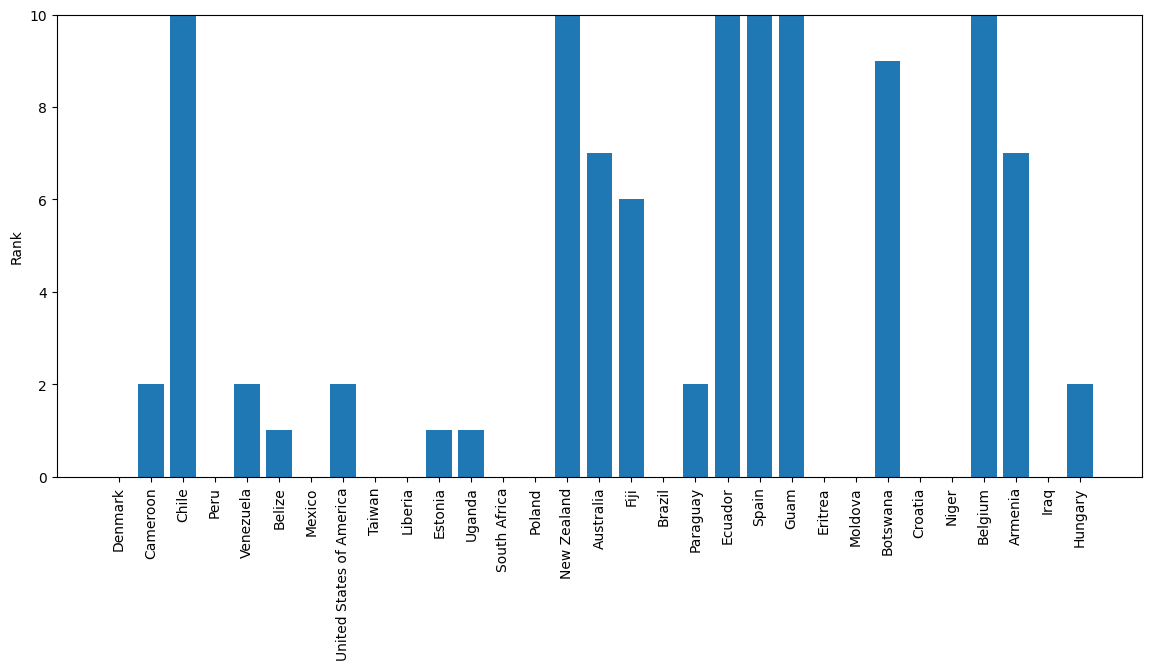

In [10]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [25]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

## Interact with server

In [40]:
dataset = Dataset()
idx = 6
print(dataset.country_name[idx])
drawing = dataset[idx]

Iran


In [41]:
drawing = to_geojson(drawing)

In [ ]:
from shapely import from_geojson
print(from_geojson(drawing))

In [42]:
import requests
#import json
from shapely import to_geojson

# Define the URL of the ML server
url = "http://localhost:5001/predict"

# Make the POST request
response = requests.post(url, json=drawing)

In [39]:
print(response.text)

<!doctype html>
<html lang=en>
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>



## Register model
Compare models and push to producton

In [108]:
#For now use the UI

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>